## Notebook Overview: Weather Data Analysis and Correlation with Lake Mixing

This notebook analyzes meteorological conditions and their relationship to lake mixing dynamics based on CTD measurements. The workflow involves loading weather station data and correlating it with water column observations to understand how atmospheric drivers influence stratification and mixing.

### Objectives:
- **Load and Clean Weather Data**: Read in weather logs from a nearby station, remove comment lines, and clean column names as needed.
- **Explore Atmospheric Trends**: Plot and inspect key weather variables such as air temperature, wind speed, and solar radiation.
- **Correlate with Water Column Data**: Join and compare weather metrics with daily mixed layer depth (MLD) values to examine patterns across time and dock locations.
- **Visualize Interactions**: Use seaborn and matplotlib to generate temporal and statistical plots showing potential links between weather fluctuations and lake stratification.

This notebook provides an initial exploration of how short-term atmospheric conditions may affect vertical water structure, with implications for understanding mixing processes and bloom risk.


In [ ]:
# . . . . Import Packages
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, pytz

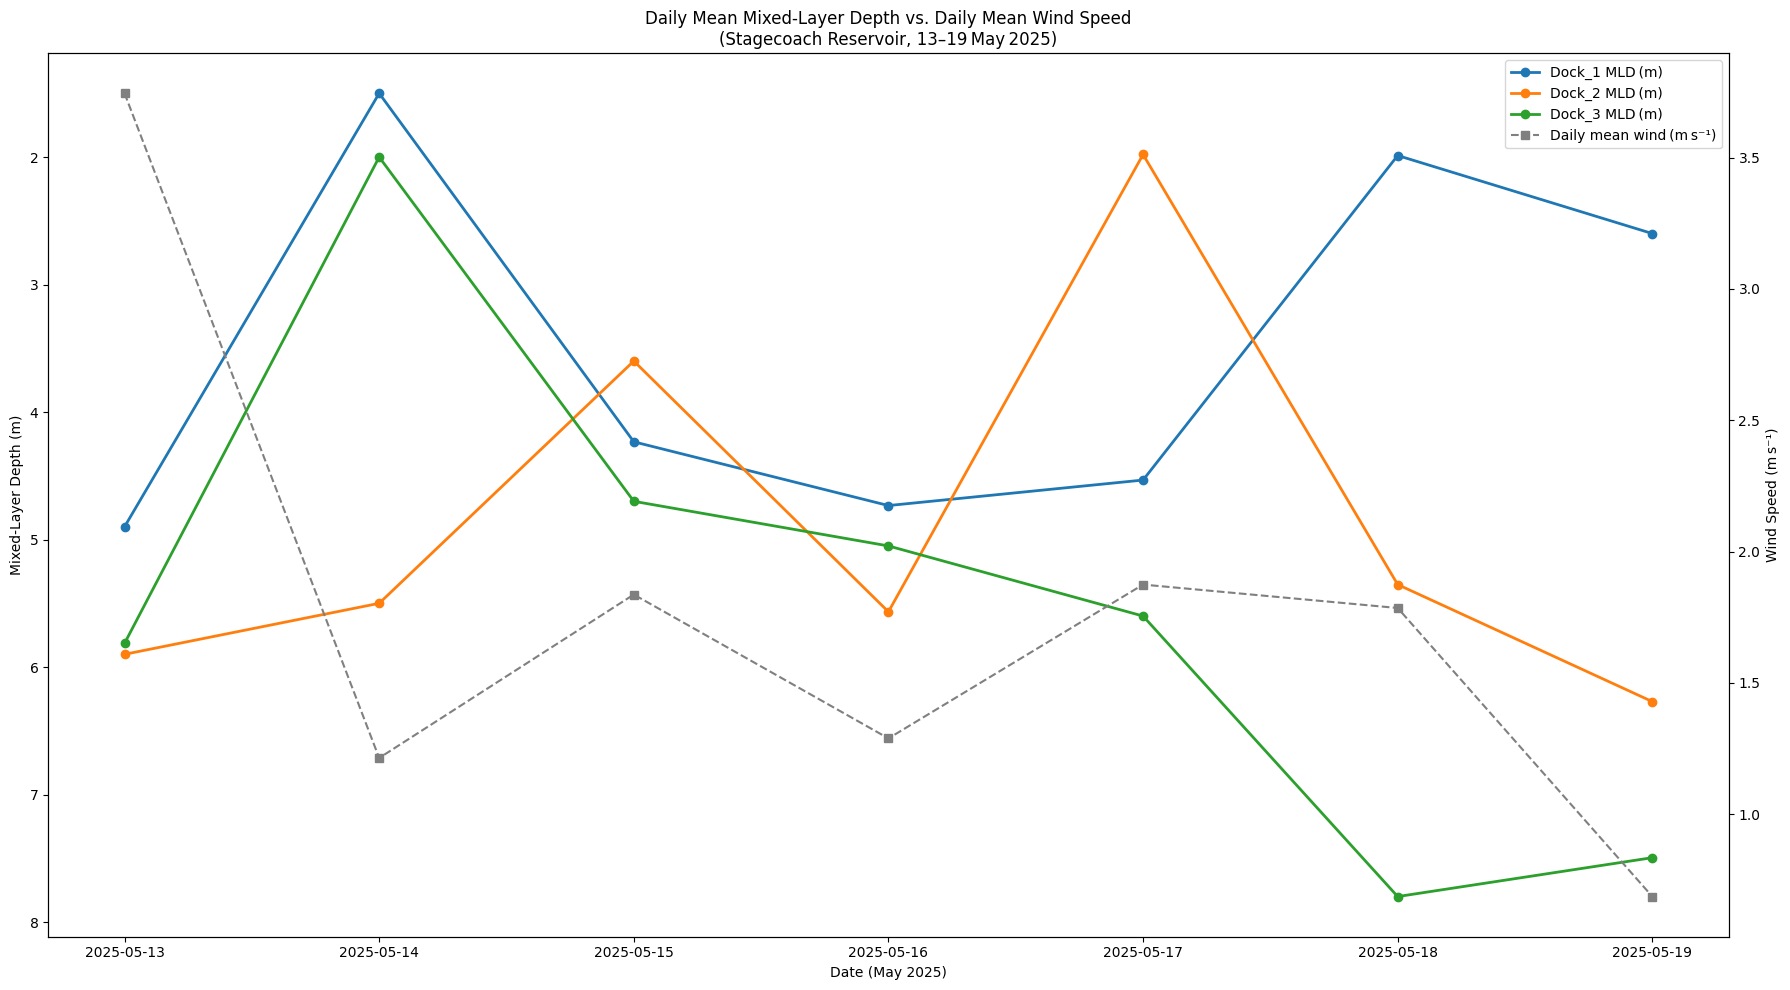

In [ ]:
# Load & clean weather data
WFILE = '/content/drive/MyDrive/Field_Camp /correlation/C3SKI.2025-05-28.csv'

wx = (pd.read_csv(WFILE, comment='#')                # ignore all lines that start with ‘#’
        .dropna(subset=['Date_Time'])                # remove the units row
        .assign(Date_Time=lambda d:
                pd.to_datetime(d['Date_Time'], utc=True))
        .rename(columns={'wind_speed_set_1': 'wind_speed'})
        .assign(datetime=lambda d: d['Date_Time'].dt.tz_convert(None))
        [['datetime', 'wind_speed']]
        .astype({'wind_speed': 'float64'})            # force numeric
      )

# Load & clean dock/CTD data
DFILE = '/content/drive/MyDrive/Field_Camp /correlation/dock_casts_with_mld_patched.csv'

mountain = pytz.timezone('America/Denver')            # local time for Steamboat Springs

dock = (pd.read_csv(DFILE)
          .rename(columns={'Cast time (local)': 'cast_local',
                           'Dock Location'     : 'dock_location',
                           'MLD'               : 'mld'})
          .assign(cast_local=lambda d: pd.to_datetime(d['cast_local'], errors='coerce'))
          .dropna(subset=['cast_local'])
          .assign(datetime_utc=lambda d:
                  d['cast_local'].dt.tz_localize(mountain)
                                   .dt.tz_convert('UTC')
                                   .dt.tz_localize(None))
          [['datetime_utc', 'dock_location', 'mld']]
          .astype({'mld': 'float64'})
       )

# Helper: mean wind speed in the N‑h window immediately before a cast
def window_means(wx, t, hours):
    window = wx.loc[(wx['datetime'] > t - pd.Timedelta(hours=hours)) &
                    (wx['datetime'] <= t), 'wind_speed']
    return window.mean()

# Build one row per cast with 6 / 12 / 24 h wind means
records = []
for t, loc, mld in dock.itertuples(index=False):
    rec = {'datetime' : t,
           'dock_location': loc,
           'mld'  : mld,
           'wind_6h' : window_means(wx, t,  6),
           'wind_12h': window_means(wx, t, 12),
           'wind_24h': window_means(wx, t, 24)}
    records.append(rec)

df = (pd.DataFrame(records)
        .drop_duplicates(['datetime', 'dock_location']))   # one point per cast



# .. . . . . . . . Daily‑mean overlay  (robust to any table/column names)

import matplotlib.pyplot as plt, pytz, pandas as pd, numpy as np

# Identify which weather DataFrame exists in memory
if   'weather_df' in globals():
    wx_df = weather_df
elif 'wx' in globals():
    wx_df = wx
else:
    raise NameError("No weather DataFrame named 'weather_df' or 'wx' found.")

# Work out the timestamp column names automatically
dock_timecol = 'datetime_utc' if 'datetime_utc' in df.columns else 'datetime'
wx_timecol   = 'datetime'     if 'datetime'     in wx_df.columns else wx_df.columns[0]

mountain = pytz.timezone('America/Denver')

# add local calendar date columns
df['local_date'] = (pd.to_datetime(df[dock_timecol], utc=True)
                      .dt.tz_convert(mountain)
                      .dt.date)

wx_df['local_date'] = (pd.to_datetime(wx_df[wx_timecol], utc=True, errors='coerce')
                         .dt.tz_convert(mountain)
                         .dt.date)

# daily averages
daily_mld  = (df
              .groupby(['local_date', 'dock_location'])['mld']
              .mean()
              .unstack())                      # Dock_1, Dock_2, Dock_3 …

daily_wind = (wx_df
              .groupby('local_date')['wind_speed']
              .mean())

combined = daily_mld.join(daily_wind, how='inner')    # only dates present in both

# plotting
fig, ax1 = plt.subplots(figsize=(18, 10))

for col in combined.columns:
    if col.startswith('Dock'):
        ax1.plot(combined.index, combined[col],
                 marker='o', linewidth=2, label=f'{col} MLD (m)')

ax1.set_ylabel('Mixed‑Layer Depth (m)')
ax1.invert_yaxis()
ax1.set_xlabel('Date (May 2025)')

ax2 = ax1.twinx()
ax2.plot(combined.index, combined['wind_speed'],
         linestyle='--', color='grey', marker='s',
         label='Daily mean wind (m s⁻¹)')
ax2.set_ylabel('Wind Speed (m s⁻¹)')

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.title('Daily Mean Mixed‑Layer Depth vs. Daily Mean Wind Speed\n(Stagecoach Reservoir, 13–19 May 2025)')
plt.xticks(rotation=45)
plt.tight_layout()

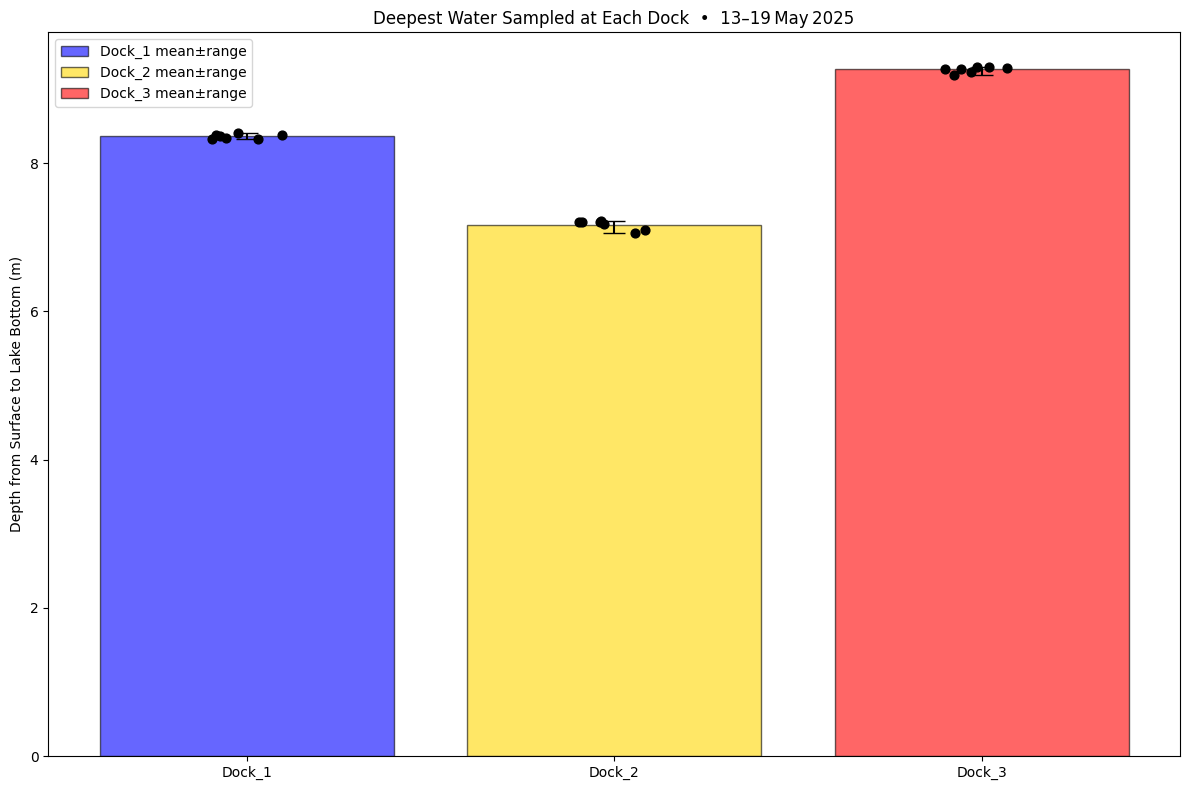

In [ ]:
# . . . . . FIND WATER DEPTH AT EACH DOCK

csv_path = '/content/drive/MyDrive/Field_Camp /correlation/dock_casts_with_mld_patched.csv'
full_df  = pd.read_csv(csv_path)

# Columns in this file
depth_col   = 'Depth (Meter)'          # confirmed by printout
time_col    = 'Cast time (local)'      # datetime column in the raw file
dock_col    = 'Dock Location'          # dock identifier

# Convert to calendar date (local clock, no tz handling needed)
full_df['ts_local']   = pd.to_datetime(full_df[time_col], errors='coerce')  # keep naïve
full_df['local_date'] = full_df['ts_local'].dt.date


# Deepest cast each day at each dock
deep_daily = (full_df
              .groupby(['local_date', dock_col])[depth_col]
              .max()
              .unstack())              # columns = Dock_1, Dock_2, Dock_3

# Summary stats
mean_depth = deep_daily.mean()
min_depth  = deep_daily.min()
max_depth  = deep_daily.max()

colors     = {'Dock_1':'blue', 'Dock_2':'gold', 'Dock_3':'red'}

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

for i, dock in enumerate(deep_daily.columns):
    ax.bar(i, mean_depth[dock],
           yerr=[[mean_depth[dock] - min_depth[dock]],
                 [max_depth[dock] - mean_depth[dock]]],
           capsize=8, color=colors.get(dock, 'grey'),
           edgecolor='black', alpha=0.6,
           label=f'{dock} mean±range')

    # black dots = each day’s max depth (jittered for clarity)
    yvals = deep_daily[dock].dropna()
    ax.scatter(np.repeat(i, len(yvals)) + np.random.uniform(-0.1, 0.1, len(yvals)),
               yvals, color='black', s=40, zorder=3)

ax.set_xticks(range(len(deep_daily.columns)), deep_daily.columns)
ax.set_ylabel('Depth from Surface to Lake Bottom (m)')
ax.set_title('Deepest Water Sampled at Each Dock  •  13–19 May 2025')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# . . . . WATER DEPTH AT DOCKS

# Make sure deep_daily exists
if 'deep_daily' not in globals():
    deep_daily = (full_df
                  .groupby(['local_date', dock_col])[depth_col]
                  .max()
                  .unstack())

# Calculate mean depth (m) per dock for 13–19 May
mean_depth_tbl = deep_daily.mean().to_frame('Mean bottom depth (m)')
print('\nWeekly‑Mean Bottom Depth  •  13–19 May 2025')
print(mean_depth_tbl.round(2).to_markdown())

# Append these numbers to the existing legend
for dock, depth in mean_depth_tbl['Mean bottom depth (m)'].items():
    ax2.scatter([], [],
                color=dock_colors.get(dock, 'grey'),
                label=f'{dock}   mean depth ≈ {depth:.1f} m')
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper right')
plt.draw()


Weekly‑Mean Bottom Depth  •  13–19 May 2025
| Dock Location   |   Mean bottom depth (m) |
|:----------------|------------------------:|
| Dock_1          |                    8.36 |
| Dock_2          |                    7.17 |
| Dock_3          |                    9.26 |


<Figure size 640x480 with 0 Axes>

## Interactive Plots Looking at Weather Correlations
### Update file path to run

In [ ]:
# Import Packages
import pandas as pd
import numpy as np
from datetime import datetime
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.dates import DateFormatter
from datetime import datetime

In [ ]:
weather_path = '/content/drive/MyDrive/Field_Camp /correlation/C3SKI.2025-05-28.csv'
wx_test = pd.read_csv(weather_path, encoding='ISO-8859-1', comment='#')
print(wx_test.columns.tolist())
wx_test.head()

['Station_ID', 'Date_Time', 'altimeter_set_1', 'air_temp_set_1', 'relative_humidity_set_1', 'wind_speed_set_1', 'wind_direction_set_1', 'wind_gust_set_1', 'snow_depth_set_1', 'solar_radiation_set_1', 'soil_temp_set_1', 'soil_temp_set_2', 'soil_temp_set_3', 'soil_temp_set_4', 'soil_temp_set_5', 'soil_temp_set_6', 'precip_accum_one_hour_set_1', 'fuel_temp_set_1', 'fuel_moisture_set_1', 'soil_moisture_set_1', 'soil_moisture_set_2', 'soil_moisture_set_3', 'soil_moisture_set_4', 'soil_moisture_set_5', 'soil_moisture_set_6', 'wind_chill_set_1d', 'wind_cardinal_direction_set_1d', 'heat_index_set_1d', 'dew_point_temperature_set_1d', 'pressure_set_1d', 'sea_level_pressure_set_1d']


,Station_ID,Date_Time,altimeter_set_1,air_temp_set_1,relative_humidity_set_1,wind_speed_set_1,wind_direction_set_1,wind_gust_set_1,snow_depth_set_1,solar_radiation_set_1,...,soil_moisture_set_3,soil_moisture_set_4,soil_moisture_set_5,soil_moisture_set_6,wind_chill_set_1d,wind_cardinal_direction_set_1d,heat_index_set_1d,dew_point_temperature_set_1d,pressure_set_1d,sea_level_pressure_set_1d
0,NaN,NaN,Pascals,Celsius,%,m/s,Degrees,m/s,Millimeters,W/m**2,...,%,%,%,%,Celsius,code,Celsius,Celsius,Pascals,Pascals
1,C3SKI,2022-09-22T06:00:00-0600,102505.93,6.57,97.51,1.21,178.71,2.0,NaN,0.0,...,12.7,13.6,10.0,18.8,NaN,S,NaN,6.2,71890.87,101174.39
2,C3SKI,2022-09-22T07:00:00-0600,102472.07,6.04,99.27,1.08,104.46,2.42,NaN,0.0,...,12.9,13.7,10.0,18.8,NaN,ESE,NaN,5.93,71867.13,101204.85
3,C3SKI,2022-09-22T08:00:00-0600,102472.07,6.76,95.03,2.72,181.54,4.09,NaN,10.48,...,12.8,13.9,10.0,18.8,4.82,S,NaN,6.01,71867.13,101118.42
4,C3SKI,2022-09-22T09:00:00-0600,102539.8,5.72,99.42,0.92,139.11,2.7,NaN,7.24,...,12.9,13.8,10.0,18.8,NaN,SE,NaN,5.63,71914.63,101309.92


In [ ]:
# . . . . WIND DYNAMICS

# File paths
dock_path = '/content/drive/MyDrive/Field_Camp /correlation/dock_casts_with_mld_patched.csv'
weather_path = '/content/drive/MyDrive/Field_Camp /correlation/C3SKI.2025-05-28.csv'

# Define naive Mountain Time range for filtering
start = datetime(2025, 5, 12)
end   = datetime(2025, 5, 20, 23, 59)

# Load and process dock data
dock_df = (
    pd.read_csv(dock_path)
    .rename(columns=lambda x: x.strip())
    .assign(
        ts_local=lambda df: pd.to_datetime(df['Cast time (local)'], errors='coerce'),
        mld=lambda df: pd.to_numeric(df['MLD'], errors='coerce'),
        depth=lambda df: pd.to_numeric(df['Depth (Meter)'], errors='coerce'),
        dock_location=lambda df: df['Dock Location'].astype(str).str.strip()
    )
    .dropna(subset=['ts_local', 'mld', 'depth'])
)

# Load and process weather data
wx_df = (
    pd.read_csv(weather_path, encoding='ISO-8859-1', comment='#')
    .rename(columns=lambda x: x.strip())
    .dropna(subset=['Date_Time'])
)

# Parse datetime in UTC, convert to Mountain Time, then make it naive
wx_df['datetime'] = pd.to_datetime(wx_df['Date_Time'], errors='coerce', utc=True)
wx_df = wx_df.dropna(subset=['datetime'])
wx_df['datetime'] = wx_df['datetime'].dt.tz_convert('America/Denver').dt.tz_localize(None)

# Extract and clean wind speed
wx_df['wind_speed'] = pd.to_numeric(wx_df['wind_speed_set_1'], errors='coerce')
wx_df = wx_df.dropna(subset=['wind_speed']).set_index('datetime').sort_index()

# Resample to hourly mean (use 'h' not 'H')
wx_hourly = wx_df['wind_speed'].resample('1h').mean()

# Filter weather and dock data to time window
wx_zoom = wx_hourly.loc[start:end]
mld_all = dock_df[(dock_df['ts_local'] >= start) & (dock_df['ts_local'] <= end)]

# Calculate mean bottom depth
depth_mean = mld_all.groupby('dock_location')['depth'].mean()

# Plot colors per dock
dock_colors = {'Dock_1': 'blue', 'Dock_2': 'gold', 'Dock_3': 'red'}

# Interactive plot
fig = make_subplots(rows=1, cols=3, shared_yaxes=True,
                    subplot_titles=[f'{dock} (mean ≈ {depth_mean[dock]:.1f} m)' for dock in dock_colors.keys()])

for i, dock in enumerate(dock_colors.keys(), start=1):
    dock_data = mld_all[mld_all['dock_location'] == dock]

    # Wind line
    fig.add_trace(go.Scatter(x=wx_zoom.index, y=wx_zoom,
                             mode='lines', line=dict(color='grey'),
                             name='Wind (m/s)', showlegend=(i == 1)),
                  row=1, col=i)

    # MLD dots
    fig.add_trace(go.Scatter(x=dock_data['ts_local'], y=dock_data['mld'],
                             mode='markers', marker=dict(size=8,
                             color=dock_colors[dock], line=dict(color='black', width=1)),
                             name='MLD (casts)', showlegend=False),
                  row=1, col=i)

    # Mean bottom depth
    fig.add_trace(go.Scatter(x=[start, end], y=[depth_mean[dock]] * 2,
                             mode='lines', line=dict(dash='dash', color=dock_colors[dock]),
                             name='Mean bottom depth', showlegend=False),
                  row=1, col=i)

fig.update_layout(height=500, width=1100,
                  title_text='Hourly Wind vs. CTD Cast MLDs  •  12–20 May 2025',
                  legend=dict(orientation='h', yanchor='bottom', y=1.02, x=0.5, xanchor='center'))

fig.show()

In [ ]:
# . . . . PRECIPITATION DYNAMICS

# Extract and clean hourly precipitation (assumes already 1-hour intervals)
wx_df['precip_mm'] = pd.to_numeric(wx_df['precip_accum_one_hour_set_1'], errors='coerce')
precip_hourly = wx_df['precip_mm'].dropna().resample('1h').mean()

# Restrict to the same time window
precip_zoom = precip_hourly.loc[start:end]

# Recalculate dock MLDs in that window (optional if unchanged)
mld_all = dock_df[(dock_df['ts_local'] >= start) & (dock_df['ts_local'] <= end)]
depth_mean = mld_all.groupby('dock_location')['depth'].mean()

# Create plot
fig = make_subplots(rows=1, cols=3, shared_yaxes=True,
                    subplot_titles=[f'{dock} (mean ≈ {depth_mean[dock]:.1f} m)'
                                    for dock in dock_colors.keys()])

for i, dock in enumerate(dock_colors.keys(), start=1):
    dock_data = mld_all[mld_all['dock_location'] == dock]

    # Precip line
    fig.add_trace(go.Scatter(x=precip_zoom.index, y=precip_zoom,
                             mode='lines', line=dict(color='purple'),
                             name='Precip (mm/hr)', showlegend=(i == 1)),
                  row=1, col=i)

    # MLD scatter
    fig.add_trace(go.Scatter(x=dock_data['ts_local'], y=dock_data['mld'],
                             mode='markers', marker=dict(size=8,
                             color=dock_colors[dock], line=dict(color='black', width=1)),
                             name='MLD (casts)', showlegend=False),
                  row=1, col=i)

    # Mean depth line
    fig.add_trace(go.Scatter(x=[start, end], y=[depth_mean[dock]] * 2,
                             mode='lines', line=dict(dash='dash', color=dock_colors[dock]),
                             name='Mean bottom depth', showlegend=False),
                  row=1, col=i)

fig.update_layout(height=500, width=1100,
                  title_text='Hourly Precipitation vs. CTD Cast MLDs  •  12–20 May 2025',
                  legend=dict(orientation='h', yanchor='bottom', y=1.02, x=0.5, xanchor='center'))

fig.show()

In [ ]:
# Ambient Air Temperature vs. MLD at each dock location

# Clean and resample air temperature
wx_df['air_temp_C'] = pd.to_numeric(wx_df['air_temp_set_1'], errors='coerce')
temp_hourly = wx_df['air_temp_C'].dropna().resample('1h').mean()

# Restrict to study window
temp_zoom = temp_hourly.loc[start:end]

# Filter MLD data to time window
mld_all = dock_df[(dock_df['ts_local'] >= start) & (dock_df['ts_local'] <= end)]
depth_mean = mld_all.groupby('dock_location')['depth'].mean()

# Set up subplots
fig = make_subplots(rows=1, cols=3, shared_yaxes=True,
                    subplot_titles=[f'{dock} (mean ≈ {depth_mean[dock]:.1f} m)'
                                    for dock in dock_colors.keys()])

for i, dock in enumerate(dock_colors.keys(), start=1):
    dock_data = mld_all[mld_all['dock_location'] == dock]

    # Temperature line
    fig.add_trace(go.Scatter(x=temp_zoom.index, y=temp_zoom,
                             mode='lines', line=dict(color='orange'),
                             name='Air Temp (°C)', showlegend=(i == 1)),
                  row=1, col=i)

    # MLD scatter points
    fig.add_trace(go.Scatter(x=dock_data['ts_local'], y=dock_data['mld'],
                             mode='markers', marker=dict(size=8,
                             color=dock_colors[dock], line=dict(color='black', width=1)),
                             name='MLD (casts)', showlegend=False),
                  row=1, col=i)

    # Mean bottom depth
    fig.add_trace(go.Scatter(x=[start, end], y=[depth_mean[dock]] * 2,
                             mode='lines', line=dict(dash='dash', color=dock_colors[dock]),
                             name='Mean bottom depth', showlegend=False),
                  row=1, col=i)

# Layout settings
fig.update_layout(height=500, width=1100,
                  title_text='Hourly Air Temperature vs. CTD Cast MLDs  •  12–20 May 2025',
                  legend=dict(orientation='h', yanchor='bottom', y=1.02, x=0.5, xanchor='center'))

fig.show()

In [ ]:
# . . . . . . Interactive Plot Showing Water vs. Air Temp.

# Re-upload Data for new analysis
ctd_path = '/content/drive/MyDrive/Field_Camp /correlation/dock_casts_with_mld_patched.csv'
wx_path  = '/content/drive/MyDrive/Field_Camp /correlation/C3SKI.2025-05-28.csv'

# ───────────────────────────────────────
# Load and preprocess weather data
# ───────────────────────────────────────
wx_df = (
    pd.read_csv(wx_path, encoding='ISO-8859-1', comment='#')
      .rename(columns=lambda x: x.strip())
      .dropna(subset=['Date_Time'])
      .assign(datetime=lambda df: pd.to_datetime(df['Date_Time'], utc=True))
      .dropna(subset=['datetime'])
      .assign(air_temp_C=lambda df: pd.to_numeric(df['air_temp_set_1'], errors='coerce'))
      .dropna(subset=['air_temp_C'])
      .set_index('datetime')
      .sort_index()
)

temp_hourly = wx_df['air_temp_C'].resample('1h').mean()

# ───────────────────────────────────────
# Load and preprocess CTD cast data
# ───────────────────────────────────────
df = (
    pd.read_csv(ctd_path)
      .rename(columns=lambda x: x.strip())
)

df = df.assign(
    temp_C=pd.to_numeric(df['Temperature (Celsius)'], errors='coerce'),
    depth_m=pd.to_numeric(df['Depth (Meter)'], errors='coerce'),
    mld=pd.to_numeric(df['MLD'], errors='coerce'),
    ts_local=pd.to_datetime(df['Cast time (local)'], errors='coerce'),
    dock_location=df['Dock Location'].astype(str).str.strip(),
    cast_id=df['Cast ID'].astype(str)
).dropna(subset=['temp_C', 'depth_m', 'mld', 'ts_local', 'cast_id', 'dock_location'])

# ───────────────────────────────────────
# Compute average temperature within MLD per cast
# ───────────────────────────────────────
def mean_temp_within_mld(cast_df):
    mld = cast_df['mld'].iloc[0]
    return cast_df[cast_df['depth_m'] <= mld]['temp_C'].mean()

temp_summary = (
    df.groupby('cast_id', group_keys=False)
      .apply(lambda group: pd.Series({
          'mean_temp_mld': mean_temp_within_mld(group),
          'ts_local': group['ts_local'].iloc[0],
          'dock_location': group['dock_location'].iloc[0]
      }))
      .reset_index()
)

# ───────────────────────────────────────
# Filter time window
# ───────────────────────────────────────
mountain = pytz.timezone('America/Denver')
start = mountain.localize(datetime(2025, 5, 12))
end   = mountain.localize(datetime(2025, 5, 20, 23, 59))

# Ensure ts_local is timezone-aware
temp_summary['ts_local'] = temp_summary['ts_local'].dt.tz_localize('America/Denver')

# Filter data in local time range
temp_summary = temp_summary[(temp_summary['ts_local'] >= start) & (temp_summary['ts_local'] <= end)]

# Convert time window to UTC for wx_df filtering
start_utc = start.astimezone(pytz.utc)
end_utc = end.astimezone(pytz.utc)
temp_zoom = temp_hourly.loc[start_utc:end_utc]

# ───────────────────────────────────────
# Plotting
# ───────────────────────────────────────
dock_colors = {'Dock_1': 'blue', 'Dock_2': 'gold', 'Dock_3': 'red'}
depth_mean = df.groupby('dock_location')['depth_m'].mean()

fig = make_subplots(
    rows=1, cols=3, shared_yaxes=True,
    subplot_titles=[
        f'{dock}  (mean depth ≈ {depth_mean.get(dock, np.nan):.1f} m)'
        for dock in dock_colors
    ]
)

for i, dock in enumerate(dock_colors, start=1):
    sub = temp_summary[temp_summary['dock_location'] == dock]

    fig.add_trace(
        go.Scatter(
            x=temp_zoom.index.tz_convert('America/Denver'), y=temp_zoom,
            mode='lines', line=dict(color='orange', width=1),
            name='Air Temp (°C)', showlegend=(i == 1)
        ),
        row=1, col=i
    )

    fig.add_trace(
        go.Scatter(
            x=sub['ts_local'], y=sub['mean_temp_mld'],
            mode='markers',
            marker=dict(color=dock_colors[dock], size=9,
                        line=dict(color='black', width=0.7)),
            name='Water Temp in MLD', showlegend=False
        ),
        row=1, col=i
    )

fig.update_layout(
    height=500, width=1100,
    title_text='Hourly Ambient Air Temperature vs. Mixed-Layer Water Temperature • 12–20 May 2025',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, x=0.5, xanchor='center'),
    margin=dict(t=60, b=40)
)
fig.update_yaxes(title_text='Temperature (°C)', row=1, col=1)
fig.update_xaxes(title_text='Date / Time (America/Denver)')

fig.show()

<ipython-input-12-04e61d3176d1>:57: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



<ipython-input-4-04146da26cae>:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


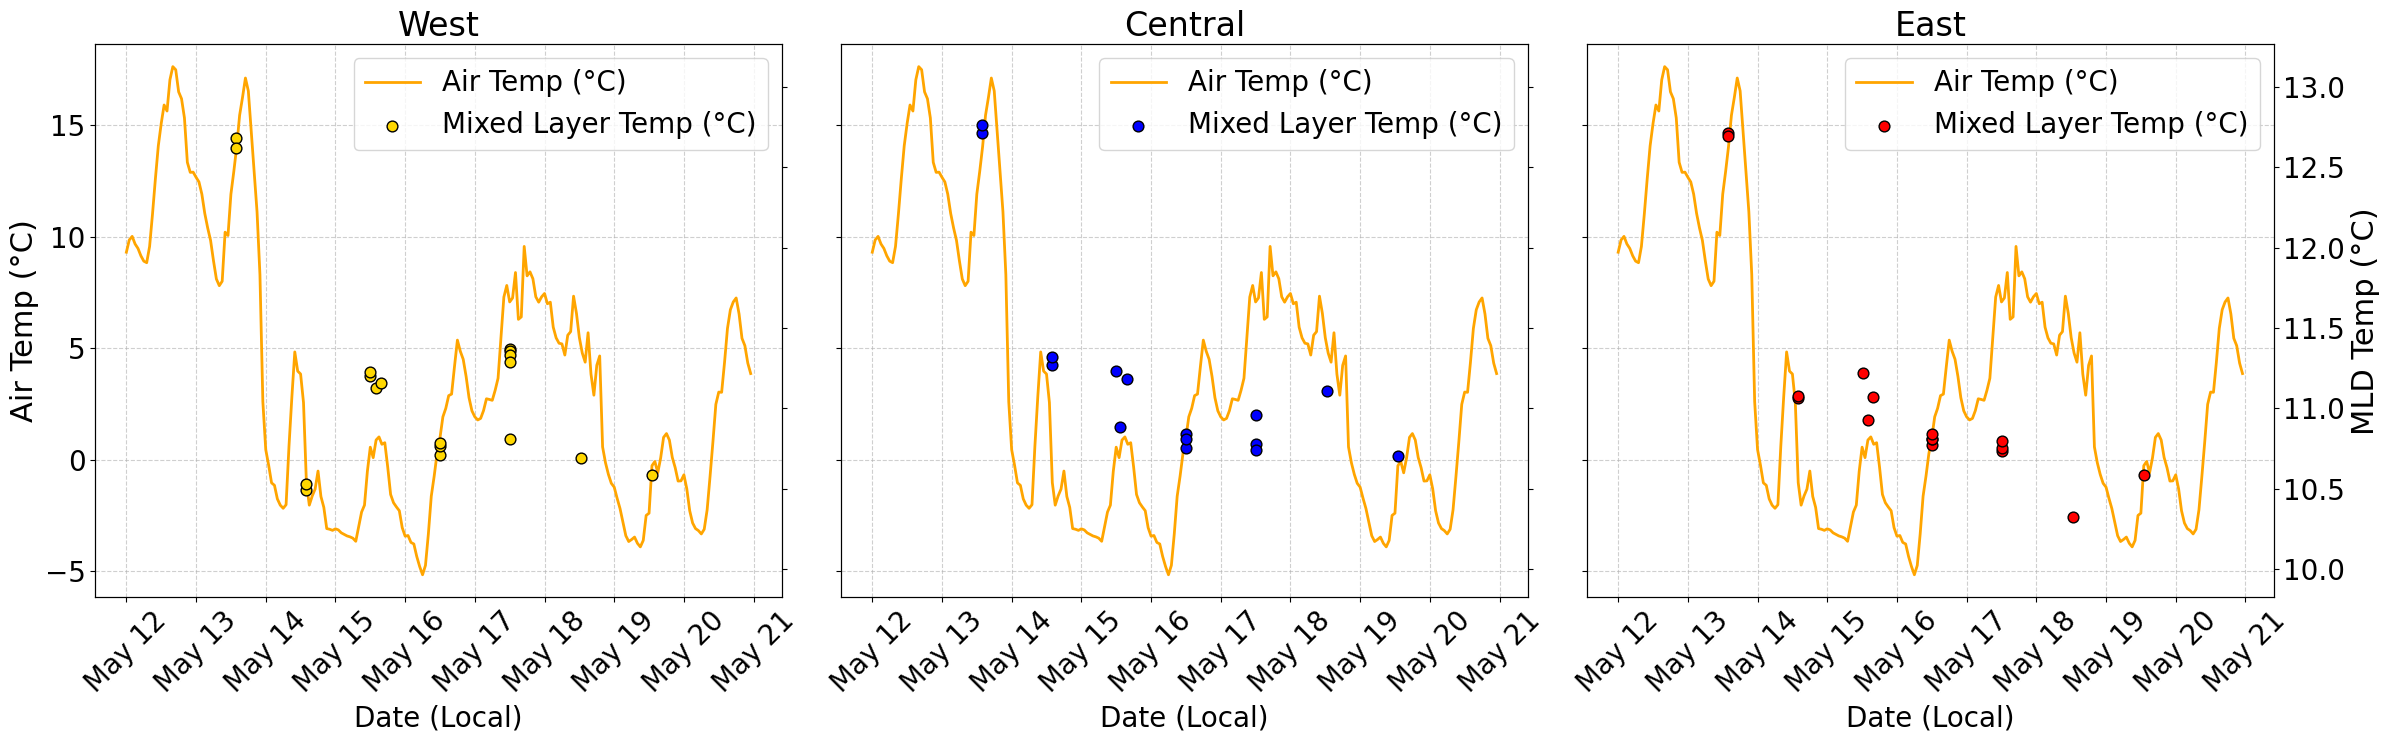

In [4]:
# . . . . . Plotting the previous plot statically for powerpoint representation

# Load and preprocess weather data
wx_df = (
    pd.read_csv(wx_path, encoding='ISO-8859-1', comment='#')
      .rename(columns=lambda x: x.strip())
      .dropna(subset=['Date_Time'])
      .assign(datetime=lambda df: pd.to_datetime(df['Date_Time'], utc=True))
      .dropna(subset=['datetime'])
      .assign(air_temp_C=lambda df: pd.to_numeric(df['air_temp_set_1'], errors='coerce'))
      .dropna(subset=['air_temp_C'])
      .set_index('datetime')
      .sort_index()
)
temp_hourly = wx_df['air_temp_C'].resample('1h').mean()

# Load and preprocess CTD cast data
df = (
    pd.read_csv(ctd_path)
      .rename(columns=lambda x: x.strip())
)

df = df.assign(
    temp_C=pd.to_numeric(df['Temperature (Celsius)'], errors='coerce'),
    depth_m=pd.to_numeric(df['Depth (Meter)'], errors='coerce'),
    mld=pd.to_numeric(df['MLD'], errors='coerce'),
    ts_local=pd.to_datetime(df['Cast time (local)'], errors='coerce'),
    dock_location=df['Dock Location'].astype(str).str.strip(),
    cast_id=df['Cast ID'].astype(str)
).dropna(subset=['temp_C', 'depth_m', 'mld', 'ts_local', 'cast_id', 'dock_location'])

# Compute average MLD temperature per cast
def mean_temp_within_mld(cast_df):
    mld = cast_df['mld'].iloc[0]
    return cast_df[cast_df['depth_m'] <= mld]['temp_C'].mean()

temp_summary = (
    df.groupby('cast_id', group_keys=False)
      .apply(lambda group: pd.Series({
          'mean_temp_mld': mean_temp_within_mld(group),
          'ts_local': group['ts_local'].iloc[0],
          'dock_location': group['dock_location'].iloc[0]
      }))
      .reset_index()
)

# Filter date range
mountain = pytz.timezone('America/Denver')
start = mountain.localize(datetime(2025, 5, 12))
end = mountain.localize(datetime(2025, 5, 20, 23, 59))
temp_summary['ts_local'] = temp_summary['ts_local'].dt.tz_localize('America/Denver', ambiguous='NaT')
temp_summary = temp_summary[(temp_summary['ts_local'] >= start) & (temp_summary['ts_local'] <= end)]
start_utc = start.astimezone(pytz.utc)
end_utc = end.astimezone(pytz.utc)
temp_zoom = temp_hourly.loc[start_utc:end_utc]

# Plotting with fixed axis limits
dock_colors = {'Dock_2': 'gold', 'Dock_1': 'blue', 'Dock_3': 'red'}
fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=False)
label_map = {'Dock_2': 'West', 'Dock_1': 'Central', 'Dock_3': 'East'}

# Determine common y-limits
air_min, air_max = temp_zoom.min(), temp_zoom.max()
mld_min = temp_summary['mean_temp_mld'].min()
mld_max = temp_summary['mean_temp_mld'].max()

for i, (ax, (dock, color)) in enumerate(zip(axs, dock_colors.items())):
    sub = temp_summary[temp_summary['dock_location'] == dock]
    ax2 = ax.twinx()

    ln1 = ax.plot(temp_zoom.index.tz_convert('America/Denver'), temp_zoom, color='orange',
                  label='Air Temp (°C)', linewidth=2)
    ln2 = ax2.scatter(sub['ts_local'], sub['mean_temp_mld'], color=color, edgecolor='black',
                      label='Mixed Layer Temp (°C)', s=60, zorder=5)

    ax.set_title(label_map[dock], fontsize=24)
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
    ax.tick_params(axis='x', labelrotation=45, labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel('Date (Local)', fontsize=20)
    ax.set_ylim(air_min - 1, air_max + 1)
    ax2.set_ylim(mld_min - 0.5, mld_max + 0.5)

    if i == 0:
        ax.set_ylabel('Air Temp (°C)', fontsize=22)
    else:
        ax.set_ylabel('', fontsize=22)
        ax.tick_params(labelleft=False)

    if i == len(axs) - 1:
        ax2.set_ylabel('MLD Temp (°C)', fontsize=22)
    else:
        ax2.set_ylabel('', fontsize=22)
        ax2.tick_params(labelright=False)

    handles = ln1 + [ln2]
    labels = [h.get_label() if hasattr(h, 'get_label') else h.get_label() for h in handles]
    ax.legend(handles, labels, loc='upper right', fontsize=20)

#fig.suptitle('Hourly Ambient Air Temperature vs. Mixed-Layer Mean Water Temperature • 12–20 May 2025', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.94])

plt.show()